In [1]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
from __future__ import division

%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import clear_output
from tqdm import tqdm
from string import ascii_lowercase
import networkx as nx

This notebook is an implementation of GeneNet from Hiscock (2019): https://doi.org/10.1186/s12859-019-2788-3.

In [2]:
np.random.seed(1)
tf.set_random_seed(1)

# Hyperparameters
B = 128 # Batch size
N = 300 # timesteps
S = 3  # number of species
dt = 0.01 # time interval
L1 = 0.003 # L1 regularization

# Data and dimensions
input_ = tf.placeholder(tf.float32, shape=[N,B,S], name='Input') 
output_ = tf.placeholder(tf.float32, shape=[B], name='Output')
initial_ = tf.placeholder(tf.float32, shape=[B,S], name='Initial')

# Parameters for optimization
W = tf.Variable(tf.random_normal([S,S], mean = 0, stddev = 0.1, dtype = tf.float32), name='weights') # normal initial values
A = tf.Variable(1.0, dtype = tf.float32, name='A')

# Alternatively define topology here to inspect circuit behaviour manually
Wdef = tf.placeholder(tf.float32, shape=[S,S], name='Topo')
topo = np.array([[10,0],[-10,1]])

# Define a nonlinearity
def phi(x):
    return 1/(tf.exp(-x)+1) # sigmoid

In [3]:
# Define ODE function in TF: use tf.scan to integrate
# This function takes initial value initial_ and integrates along time (S) axis

def simulate(input_, initial_, W):
    output = tf.scan(lambda o,i: o + dt*(phi(tf.matmul(o,W))-o+i),
                    elems = input_,
                    initializer = initial_,
                    swap_memory = True)
    return output

output = simulate(input_, initial_, W) # Params for training

In [4]:
relevantOutput = A*output[N-1,:,1] # final timepoint for species 1 is all we are interested in

# Cost function definition
cost = tf.reduce_mean(tf.square(((relevantOutput-output_)))) + L1*tf.reduce_mean(tf.abs(W)) # with L1
optimizer = tf.train.AdamOptimizer(learning_rate=0.2, beta1=0.98, beta2=0.999, epsilon=1e-08)
train_step = optimizer.minimize(cost)

In [5]:
# generate training data
def newBatch(plot=False):
# Batch of size B contains randomly distributed initial concentrations of species 1

    initialVal = 0.1*np.ones([B,S]) # some small initial value
    if(plot):
        inputNoNoise    = np.linspace(0,2,B) # ordered inputs for plot
    else:
        inputNoNoise    = np.random.uniform(0,2,B)
    inputVal = inputNoNoise.reshape(B,1) * np.random.normal(loc=1.0, scale = 0.0001, size=[N,B,S])
    inputVal[:,:,1:S] = 0.0 # all concentrations 0 apart from species 1 which is uniformly distributed [0,2]
    outputNoNoise = np.zeros(B)
    outputNoNoise[np.logical_and(inputNoNoise > 0.5,inputNoNoise < 1.5 )] = 1.0 # where input between 0.5 and 1.5 output is 1 else 0
    return [inputNoNoise, inputVal, outputNoNoise, initialVal]

In [6]:
def trainModel(iterations, outputEvery=50, plot=True):
# Train for set number of iterations, plot every set number of points

    if plot:
        fig = plt.figure()
    
    else:
        pass

    # Run
    
    for i in tqdm(range(iterations)):
        [_,inputVal, outputVal, initialVal] = newBatch(plot=False)
        _,loss_value = sess.run((train_step,cost), feed_dict = {input_: inputVal, initial_: initialVal, output_: outputVal})
        
        if i==0:
            itera = np.array([i])
            losscurve = np.array([loss_value])
        elif i%outputEvery==0:
            itera = np.append(itera,i)
            losscurve = np.append(losscurve,loss_value)
            
            [inputNoNoise,inputVal, outputVal, initialVal] = newBatch(plot=True)
            finalOutput = sess.run(relevantOutput, feed_dict = {input_: inputVal, initial_: initialVal, output_: outputVal})
            
            if plot:
                f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,4))
                clear_output(wait=True)

                ax1.plot(itera,losscurve,label='loss')
                ax1.set_xlabel('Iteration'); ax1.set_ylabel('Loss');
#                ax1.legend()
                
                ax2.plot(inputNoNoise,finalOutput,label='output');
                ax2.plot(inputNoNoise,outputVal,'o',label='target output');
                ax2.set_xlabel('Input'); ax2.set_ylabel('Output');
#                ax2.legend()
      
                weights = sess.run(W)
                G = nx.MultiDiGraph(weights)
                labels={}
                for idx, node in enumerate(G.nodes()):
                    labels[node] = ascii_lowercase[idx]

                nx.set_node_attributes(G,labels,'labels')
                edge_colors = [j for i in weights for j in i]

                # Add self loops as explicit nodes: no way to do this in networkx...
                dim = G.number_of_nodes()
                for i in range(dim):
                    G.add_node(dim+i)
                    G.add_edge(i, dim+i, weight=weights[i,i])
                    edge_colors.insert(3+4*i, weights[i,i])

                pos = nx.layout.spring_layout(G, weight=None, k=0.1, seed=1)
                nodes = nx.draw_networkx_nodes(G, pos, node_color='grey')
                edges = nx.draw_networkx_edges(G, pos, arrowstyle='->', connectionstyle="arc3,rad=0.3",
                                               arrowsize=10, edge_color=edge_colors,
                                               edge_cmap=plt.cm.RdBu, width=2)
                nx.draw_networkx_labels(G,pos,labels)

                ax3 = plt.gca()
                ax3.set_axis_off()

                plt.show();
                
            else:
                print('Iteration = '+str(i)+', Loss = '+str(loss_value))
                

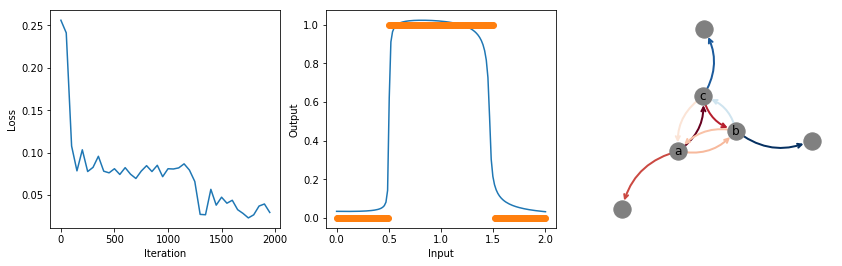

100%|██████████| 2000/2000 [02:28<00:00, 13.47it/s]


In [7]:
# Train and plot
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
trainModel(iterations=2000, outputEvery=50, plot=True)


[[ -6.4017005  -3.0497162 -10.121229 ]
 [ -2.4318218  10.911107    2.4343324]
 [ -0.8572158  -7.7670584   9.1362095]]


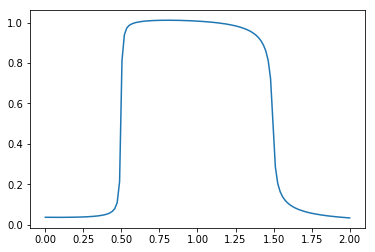

In [8]:
def simulateModelFinal():
    [inputNoNoise,inputVal, outputVal, initialVal] = newBatch(plot=True)
    finalOutput = sess.run(relevantOutput, feed_dict = {input_: inputVal, initial_: initialVal, output_: outputVal})
    weights = sess.run(W)
    print(weights);
    plt.plot(inputNoNoise,finalOutput);
    plt.show()
    return(weights)

finalmodel=simulateModelFinal()